In [1]:
# Import Libraries
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.sql.functions import when
from matplotlib import pyplot as plt

# Initialize Spark Object
spark = SparkSession.builder.getOrCreate()

# tab == auto complete

+-------------+------------------+------------------+--------------------------------------+
|close_friends|supportive_friends|supportive_parents|Most_of_the_time_or_always_felt_lonely|
+-------------+------------------+------------------+--------------------------------------+
|            3|                 1|                 5|                                     1|
|            4|                 3|                 5|                                     2|
|            4|                 3|                 5|                                     2|
|            4|                 4|                 4|                                     2|
|            4|                 4|                 5|                                     2|
|            4|                 4|                 5|                                     2|
|            4|                 4|                 1|                                     2|
|            4|                 4|                 4|                 

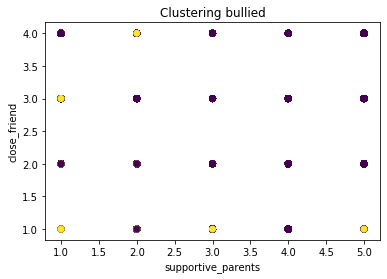

In [4]:
# Local Dataset
dataset = spark.read.option('inferSchema', 'true').csv('Bullying_2018.csv', header=True)

# Select Features
dataset = dataset.select('close_friends', 
                         'supportive_friends', 
                         'supportive_parents',
                        'Most_of_the_time_or_always_felt_lonely')


# Preprocess
dataset = dataset.na.drop()
dataset = dataset.filter(dataset['close_friends'] != 'null')
dataset = dataset.filter(dataset['supportive_friends'] != 'null')
dataset = dataset.filter(dataset['supportive_parents'] != 'null')
dataset = dataset.filter(dataset['Most_of_the_time_or_always_felt_lonely'] != 'null')


# Transform
def transform(df):
    df = df.withColumn('close_friends', when(df['close_friends'] == '0', 1)\
                                      .when(df['close_friends'] == '1', 2)\
                                      .when(df['close_friends'] == '2', 3)\
                                      .when(df['close_friends'] == '3 or more', 4))
    df = df.withColumn('supportive_friends', when(df['supportive_friends'] == 'Always', 5)\
                                      .when(df['supportive_friends'] == 'Most of the time', 4)\
                                      .when(df['supportive_friends'] == 'Sometimes', 3)\
                                      .when(df['supportive_friends'] == 'Rarely', 2)\
                                      .when(df['supportive_friends'] == 'Never', 1))
    df = df.withColumn('supportive_parents', when(df['supportive_parents'] == 'Always', 5)\
                                      .when(df['supportive_parents'] == 'Most of the time', 4)\
                                      .when(df['supportive_parents'] == 'Sometimes', 3)\
                                      .when(df['supportive_parents'] == 'Rarely', 2)\
                                      .when(df['supportive_parents'] == 'Never', 1))
    df = df.withColumn('Most_of_the_time_or_always_felt_lonely', when(df['Most_of_the_time_or_always_felt_lonely'] == 'Yes', 1)\
                                      .when(df['Most_of_the_time_or_always_felt_lonely'] == 'No', 2))
    return df
                       
dataset = transform(dataset)

dataset.show()
                       
# Normalization
cols = dataset.columns
assembler = VectorAssembler(inputCols=cols, outputCol='assembled_features')
assembled_features = assembler.transform(dataset)
scaler = StandardScaler(inputCol='assembled_features', outputCol='features').fit(assembled_features)
normalized_dataset = scaler.transform(assembled_features)

# Generate Model
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(normalized_dataset)
                       
# Result
prediction = model.transform(normalized_dataset)
                       
#Visualization
prediction_pd = prediction.toPandas()
plt.scatter(prediction_pd['supportive_parents'], prediction_pd['close_friends'], c=prediction_pd['prediction'])
plt.title('Clustering bullied')
plt.xlabel('supportive_parents')
plt.ylabel('close_friend')
plt.show()